This notebook generates a single linear model using the combined OKID and ERA algorithms


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

config = dotenv_values(".env")


In [2]:
# Read in data 
filepath = config["currentDirectory"] + "data/processedData/cleanedArrays.npz"

with np.load(filepath) as data:
    stateData = data['stateData']
    inputData = data['inputData']
    centerlineData = data['centerlineData']


In [3]:
# Subtract initial state from everything to shift states to origin
stateData_centered = stateData-stateData[0,:]
centerlineData_centered = centerlineData-centerlineData[0,:]

# Reshape data 
centerlineData_centeredT = np.transpose(centerlineData_centered) 
inputDataT = np.transpose(inputData) 

In [4]:
####### OKID #########

# Form data matrices for OKID
YY = centerlineData_centeredT
UU_size = (inputDataT.shape[0]*inputDataT.shape[1],inputDataT.shape[1])
UU = np.zeros(UU_size)

for i in range(inputDataT.shape[1]):
    startRow = inputDataT.shape[0]*i 
    endRow = inputDataT.shape[0]*(i+1)
    UU[startRow:endRow,i:]=inputDataT[:,0:(inputDataT.shape[1]-i)]
 
# compute pseudoinverse of input matrix
UU_pinv = np.linalg.pinv(UU)
# Solve for impulse response  
IR = np.matmul(YY,UU_pinv)


## ERA

In [5]:
####### ERA ########## 
numInputs = 4
numOutputs = centerlineData[0,:].size
m = numInputs
p = numOutputs

# Form Hankel matrix for ERA 
N = 500 # num of timesteps to include in hankel matrix
H_size = (numOutputs*N,numInputs*N)

H  = np.zeros(H_size)
Hprime = np.zeros(H_size)
for i in range(N):
    startRow = numOutputs*i 
    endRow = numOutputs*(i+1)
    H[startRow:endRow,:]=IR[:,numInputs*(1+i):numInputs*(1+i+N)]
    Hprime[startRow:endRow,:]=IR[:,numInputs*(2+i):numInputs*(2+i+N)]





In [6]:
# Get singular value decomposition of H matrix
U, Sigma, Vh = np.linalg.svd(H, full_matrices=False)

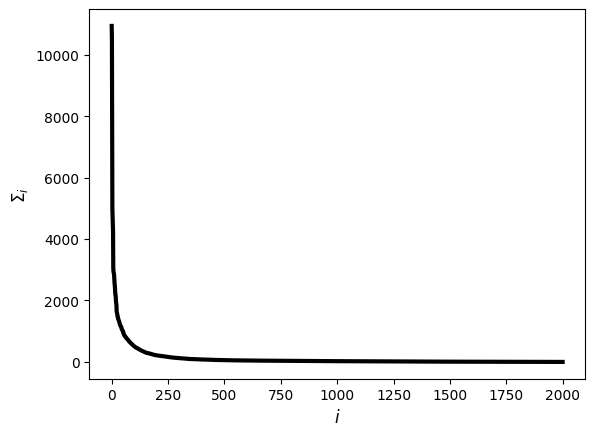

In [7]:
# Plot sigmas to get the appropriate r
plt.plot(Sigma,'k-',lw=3) 
plt.xlabel(r"$i$", fontsize=12, family="serif") 
plt.ylabel(r"$\Sigma_i$", fontsize=12, family="serif")
plt.show()

In [8]:
#Truncate svd
r = 200
U_tilde = U[:,0:r]
Sigma_tilde = np.diag(Sigma[0:r])
Vh_tilde = Vh[0:r,:]


In [9]:
# Solve for system matrices 
Sigma_tilde_is = np.linalg.inv(np.sqrt(Sigma_tilde)) # inverse squareroot of sigma matrix
Sigma_tilde_sqrt = np.sqrt(Sigma_tilde)


Em = np.concatenate([np.eye(m),np.zeros((m*(N-1),m))],axis=0)
Ep = np.concatenate([np.eye(p),np.zeros((p*(N-1),p))],axis=0)

A_tilde = np.matmul(np.matmul(np.matmul(np.matmul(Sigma_tilde_is,np.transpose(U_tilde)),Hprime),np.transpose(Vh_tilde)),Sigma_tilde_is)
B_tilde = np.matmul(np.matmul(Sigma_tilde_sqrt,Vh_tilde),Em)
C_tilde = np.matmul(np.transpose(Ep),np.matmul(U_tilde,Sigma_tilde_sqrt))
D_tilde = IR[:,:numInputs]


## Verification

In [10]:
# Read in verification data
# Read in data 
testFilepath = config["currentDirectory"] + "data/processedData/testSet.npz"

with np.load(testFilepath) as data:
    stateData_test= data['stateData']
    inputData_test = data['inputData']
    centerlineData_test = data['centerlineData']
# Subtract initial state from everything to shift states to origin
stateData_test_centered = stateData_test-stateData_test[0,:]
centerlineData_test_centered = centerlineData_test-centerlineData_test[0,:]

# Reshape data 
centerlineData_test_centeredT = np.transpose(centerlineData_test_centered) 
inputData_testT = np.transpose(inputData_test) 


In [11]:
##### Verification on test data set #######
timesteps = 1000
xs = np.zeros((r,timesteps))
us = inputData_testT[:,:timesteps]
ys = np.zeros((numOutputs,timesteps))
#
for i in range(timesteps-1):
    x = np.reshape(xs[:,i],(r,1))
    u = np.reshape(us[:,i],(numInputs,1))
    xs[:,i+1] = np.squeeze(np.matmul(A_tilde,x) + np.matmul(B_tilde,u))
    ys[:,i+1] = np.squeeze(np.matmul(C_tilde,x) + np.matmul(D_tilde,u))

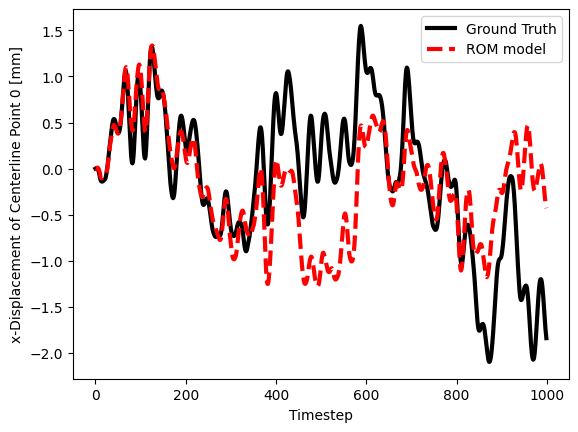

In [12]:
plt.plot(range(timesteps),centerlineData_test_centeredT[0,0:timesteps], 'k-',lw=3)
plt.plot(range(timesteps),ys[0,:],'r--',lw=3)
plt.legend(['Ground Truth','ROM model'])
plt.xlabel('Timestep')
plt.ylabel('x-Displacement of Centerline Point 0 [mm]')

plt.show()


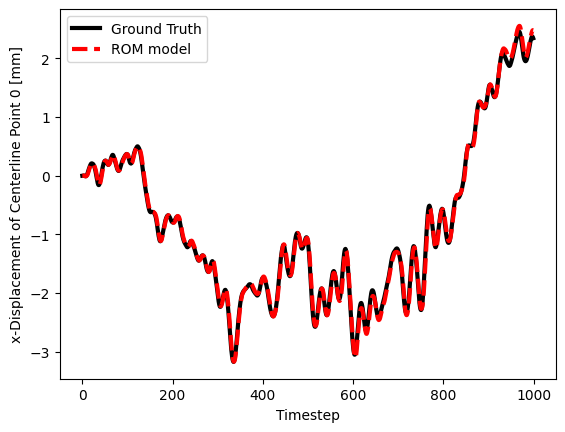

In [13]:
##### Verification on learning data set #######
timesteps = 1000
xs = np.zeros((r,timesteps))
us = inputDataT[:,:timesteps]
ys = np.zeros((numOutputs,timesteps))
#
for i in range(timesteps-1):
    x = np.reshape(xs[:,i],(r,1))
    u = np.reshape(us[:,i],(numInputs,1))
    xs[:,i+1] = np.squeeze(np.matmul(A_tilde,x) + np.matmul(B_tilde,u))
    ys[:,i+1] = np.squeeze(np.matmul(C_tilde,x) + np.matmul(D_tilde,u))


plt.plot(range(timesteps),centerlineData_centeredT[0,0:timesteps], 'k-',lw=3)
plt.plot(range(timesteps),ys[0,:],'r--',lw=3)
plt.legend(['Ground Truth','ROM Prediction'])
plt.xlabel('Timestep')
plt.ylabel('x-Displacement of Centerline Point 0 [mm]')

plt.show(block=True)

ys_uncentered= ys


Generate animation


In [ ]:
# configure video to be saved
savePath = config["currentDirectory"] +"data/visualizations/" 
# files = dir_list = os.listdir(filepath)
numFrames = 1000#np.size(files) 
# Setup figure for plotting data
fig = plt.figure()
gs = mpl.gridspec.GridSpec(2,2,wspace=0.25,hspace=0.25)
# ax = fig.add_subplot(gs[0,:],projection='3d')
ax = fig.add_subplot(gs[0,:])
ax1=fig.add_subplot(gs[1,0])
ax2=fig.add_subplot(gs[1,1])
fps = 40
duration = numFrames/fps



xlim_max = 300
xlim_min = -250 
zlim_max = 50
zlim_min = -50


ulim_max = 0.2
ulim_min = -0.2

def animate(t):
    global inputData 
    global centerlineData
    global centerlineData_test 

    i = int(round(t*fps))

    # Read in data from files
    centerline_frame_groundTruth =np.reshape(centerlineData_test[i,:],(-1,3))
    centerline_frame_ROM = np.reshape(np.squeeze(ys[:,i])+np.squeeze(centerlineData_test[0,:]),(-1,3))
    print(i)
    xs_groundTruth = centerline_frame_groundTruth[:,0]
    zs_groundTruth = centerline_frame_groundTruth[:,2]

    xs_ROM = centerline_frame_ROM[:,0]
    zs_ROM = centerline_frame_ROM[:,2]


    # plot centerline data 
    ax.clear()
    ax.scatter(xs_groundTruth, zs_groundTruth, marker='o',color='black')
    ax.scatter(xs_ROM, zs_ROM, marker='o',color='red')
    
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("z [mm]")
    # ax.set_ylabel("y [mm]")
    # ax.set_zlabel("z [mm]")
    ax.set_xlim(xlim_min,xlim_max)
    # ax.set_zlim(zlim_min,zlim_max)
    ax.set_ylim(zlim_min,zlim_max)

    # ax.view_init(0, -90, 0)


    # Plot segment 0 pressures 
    ax1.clear()
    ax1.plot(inputData[0:i+1,0], inputData[0:i+1,1],color = 'blue')
    ax1.scatter(inputData[i+1,0], inputData[i+1,1], marker='o',color = 'red')
    ax1.set_xlim(ulim_min,ulim_max)
    # ax.set_zlim(zlim_min,zlim_max)
    ax1.set_ylim(ulim_min,ulim_max)

    # Plot segment 1 pressures
    ax2.clear()
    ax2.plot(inputData[0:i+1,2], inputData[0:i+1,3],color = 'blue')
    ax2.scatter(inputData[i+1,2], inputData[i+1,3], marker='o',color = 'red')
    ax2.set_xlim(ulim_min,ulim_max)
    # ax.set_zlim(zlim_min,zlim_max)
    ax2.set_ylim(ulim_min,ulim_max)

    # fig.savefig(savePath+i.__str__()+".png")
    # plt.show(block=True)
    # returning numpy image
    return mplfig_to_npimage(fig)


# # run the animation
# ani = FuncAnimation(fig, animate, frames=100, interval=100, repeat=False)

# plt.show()

# Save video
animation = VideoClip(animate, duration = duration)
animation.write_gif(savePath + "verification.gif",fps=fps)

